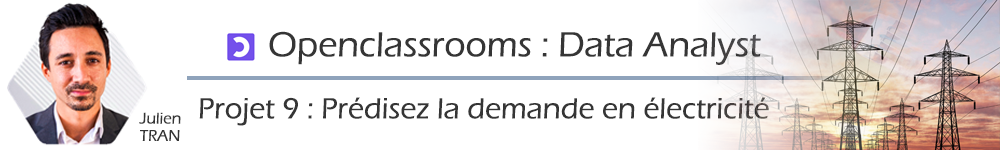

### Mission 1 : Corrigez les données de consommation mensuelles de l'effet température (dues au chauffage électrique) en utilisant une régression linéaire.

### Sommaire // Mission 1 

* [1.Importation des librairies et parametres df](#1)
* [2.Importation des fichiers CSV](#2)
* [3.Nettoyage des différentes tables](#3)
    * [3.1.data_conso](#3.1)
    * [3.2.data_chauffage_elec](#3.2)
    * [3.3.Jointure des tables](#3.3)
* [4.Regression linéaire](#4)
* [5.Test de normalité des résidus](#5)

## 1.Importation des librairies et parametres df <a class="anchor" id="1"></a>

In [1]:
#j'importe les librairies qui vont me servir plus tard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import statsmodels.api as sm

import statsmodels

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.gofplots import ProbPlot
from scipy.stats import shapiro


#Je definis le nombre de lignes max affichées sur None
pd.set_option("max_rows", None) 
pd.set_option("display.precision",7)

## 2.Importation des fichiers CSV <a class="anchor" id="2"></a>

In [2]:
#Je charge tous les fichiers csv
#data_conso = pd.read_csv("C:/Users/33643/Desktop/P9/10052022/P9.csv",sep=';',decimal=".")
#data_chauffage_pro = pd.read_csv("C:/Users/33643/Desktop/P9/10052022/dju_france_moy.csv",sep=';',decimal=",")

data_conso = pd.read_csv("D:/DA_P9/NEW/P9.csv",sep=';',decimal=".")
data_chauffage_pro = pd.read_csv("D:/DA_P9/NEW/dju/dju_france_moy.csv",sep=';',decimal=",")


#J'affiche une phrase si l'import est reussi
print("Fichiers chargés avec succes!")

Fichiers chargés avec succes!


## 3.Nettoyage des différentes tables <a class="anchor" id="3"></a>

## 3.1.data_conso <a class="anchor" id="3.1"></a>

In [3]:
data_conso.head(3)

,Mois,Qualité,Territoire,Production totale,Production nucléaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,...,Echanges avec le Royaume-Uni,Echanges avec l'Espagne,Echanges avec l'Italie,Echanges avec la Suisse,Echanges avec l'Allemagne et la Belgique,Pompage,Stockage batterie,Déstockage batterie,Eolien terrestre,Eolien offshore
0,2010-01,Données définitives,France,56542.0,40313.0,8801.0,2928.0,1690.0,4184.0,6307.0,...,-652.0,-358.0,1297.0,1613.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-02,Données définitives,France,50406.0,36316.0,6822.0,1893.0,1175.0,3754.0,5887.0,...,-497.0,-333.0,1628.0,1752.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-03,Données définitives,France,51071.0,35984.0,7250.0,1994.0,1275.0,3981.0,6204.0,...,-365.0,-360.0,1784.0,2022.0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Restriction pour la France (consommation totale)
data_conso = data_conso.loc[(data_conso['Territoire'] == 'France')]

# Selection des colonnes à garder
data_conso = data_conso[['Mois', 'Consommation totale']]

# Je renomme ma colonne Consommation
data_conso.rename(columns={'Mois': 'Date'}, inplace=True)

# Conversion de la colonne Date au format date
data_conso['Date'] = pd.to_datetime(data_conso['Date'],format = "%Y-%m")

data_conso.head()

,Date,Consommation totale
0,2010-01-01,56342.0
1,2010-02-01,48698.0
2,2010-03-01,48294.0
3,2010-04-01,38637.0
4,2010-05-01,37284.0


In [5]:
#data_conso.to_csv("C:/Users/33643/Desktop/P9/10052022/data_conso.csv", index=False)
data_conso.to_csv("D:/DA_P9/NEW/12052022/data_conso.csv", index=False)

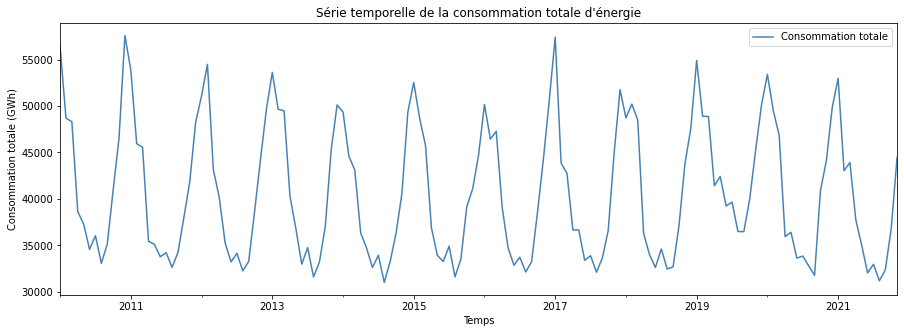

In [6]:
# Représentation graphique de la série temporelle data_conso

data_conso.plot(x='Date', y='Consommation totale', color="steelblue",figsize=(15,5))
plt.xlabel('Temps')
plt.ylabel('Consommation totale (GWh)')
plt.title('Série temporelle de la consommation totale d\'énergie')
plt.show()

### On distingue ci-dessus des cycles cliées à la saisonnalité.

## 3.2.data_chauffage_elec <a class="anchor" id="3.2"></a>

In [7]:
data_chauffage_pro.head(10)

,year,jan,fev,mar,avr,mai,juin,jui,aou,sep,oct,nov,dec
0,2021,416.5,282.9,295.6,252.1,164.5,22.4,0.0,0.0,0.0,0.0,0.0,0.0
1,2020,350.2,268.8,284.8,159.6,108.6,65.2,37.3,25.7,69.7,174.9,236.3,358.5
2,2019,416.7,289.1,261.6,211.2,161.0,57.3,28.4,35.3,69.3,126.1,291.4,318.4
3,2018,308.6,403.6,323.1,161.9,106.6,39.8,17.5,29.5,66.3,156.3,266.6,322.9
4,2017,463.2,279.3,236.4,221.0,109.2,39.1,28.3,35.8,96.6,165.3,302.0,386.0
5,2016,348.3,314.4,319.2,214.7,126.3,52.2,30.0,32.8,51.6,181.2,277.5,382.1
6,2015,391.6,370.3,287.7,185.9,121.7,51.2,26.6,32.1,95.4,181.2,223.1,271.4
7,2014,334.4,295.9,272.5,171.2,136.3,52.0,30.4,49.1,57.1,107.8,217.6,366.3
8,2013,413.1,401.8,342.3,230.0,181.0,77.3,21.2,37.1,70.0,115.0,303.2,363.0
9,2012,370.7,461.3,250.4,233.9,118.2,57.0,45.3,27.4,87.3,157.0,274.6,360.4


### A partir de cette table on souhaite obtenir la meme table que pour la table data_conso, l'année 2021 présente des donnée manquantes, je décide donc de supprimer la ligne pour cette année.

In [8]:
# Suppression de la premiere ligne
data_chauffage_pro.drop([0, 0], axis=0, inplace=True)

# Je défini la premiere colonne comme index
data_chauffage_pro.set_index("year", inplace = True)

# Je renomme les mois en nombre 01,02, etc.
data_chauffage_pro = data_chauffage_pro.rename(columns={"jan": "01","fev": "02","mar": "03","avr": "04","mai": "05","juin": "06","jui": "07","aou": "08","sep": "09","oct": "10","nov": "11","dec": "12"})

data_chauffage_pro.head()

,01,02,03,04,05,06,07,08,09,10,11,12
year,,,,,,,,,,,,
2020,350.2,268.8,284.8,159.6,108.6,65.2,37.3,25.7,69.7,174.9,236.3,358.5
2019,416.7,289.1,261.6,211.2,161.0,57.3,28.4,35.3,69.3,126.1,291.4,318.4
2018,308.6,403.6,323.1,161.9,106.6,39.8,17.5,29.5,66.3,156.3,266.6,322.9
2017,463.2,279.3,236.4,221.0,109.2,39.1,28.3,35.8,96.6,165.3,302.0,386.0
2016,348.3,314.4,319.2,214.7,126.3,52.2,30.0,32.8,51.6,181.2,277.5,382.1


In [9]:
# Création d'un dictionnaire avec deux colonnes, comme pour data_conso
data_dju = {'Date':[],'DJU':[]}

# Création d'une boucle pour ajouter les dates au meme format y/m que data_conso et les valeurs de la table data_chauffage_pro
for year in data_chauffage_pro.index.values:
    for mois in data_chauffage_pro.columns:
        data_dju['Date'].append(f"{year}-{mois}")
        data_dju['DJU'].append(data_chauffage_pro.loc[year,mois])

# Création de la table à partir du dictionnaire data_dju 
data_dju = pd.DataFrame(data_dju)

# Conversion de la colonne Date au format date
data_dju['Date'] = pd.to_datetime(data_dju['Date'],format = "%Y-%m")

In [10]:
data_dju.head()

,Date,DJU
0,2020-01-01,350.2
1,2020-02-01,268.8
2,2020-03-01,284.8
3,2020-04-01,159.6
4,2020-05-01,108.6


In [11]:
# Je check les types de données de chaque colonne
data_dju.dtypes

Date    datetime64[ns]
DJU            float64
dtype: object

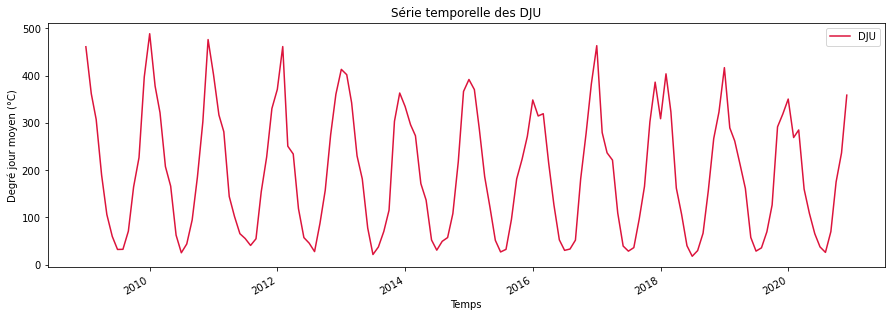

In [12]:
# Représentation graphique de la série temporelle data_dju

data_dju.plot(x='Date', y='DJU', color="crimson",figsize=(15,5))
plt.xlabel('Temps')
plt.ylabel('Degré jour moyen (°C)')
plt.title('Série temporelle des DJU')
plt.show()

### Naturellement la serie temporelle suit la consommation selon la saisonnalité liées aux conditions climatiques.

In [13]:
# Merge des deux dataframe
data_p9 = pd.merge(data_conso, data_dju, how='inner', on='Date')
data_p9.rename(columns = {'Consommation totale':'Consommation_totale'}, inplace = True)

data_p9.head()

,Date,Consommation_totale,DJU
0,2010-01-01,56342.0,488.5
1,2010-02-01,48698.0,377.6
2,2010-03-01,48294.0,321.4
3,2010-04-01,38637.0,207.3
4,2010-05-01,37284.0,165.9


## 4.Regression linéaire <a class="anchor" id="4"></a>

In [14]:
Regression_lineaire_P9 = smf.ols('Consommation_totale ~ DJU', data=data_p9).fit()

print(Regression_lineaire_P9.summary())

                             OLS Regression Results                            
Dep. Variable:     Consommation_totale   R-squared:                       0.920
Model:                             OLS   Adj. R-squared:                  0.919
Method:                  Least Squares   F-statistic:                     1497.
Date:                 Mon, 23 May 2022   Prob (F-statistic):           3.43e-73
Time:                         13:24:54   Log-Likelihood:                -1192.3
No. Observations:                  132   AIC:                             2389.
Df Residuals:                      130   BIC:                             2394.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.056e+04    317.026     96.40

### Le coefficient de détermination de 92% est très satisfaisant.

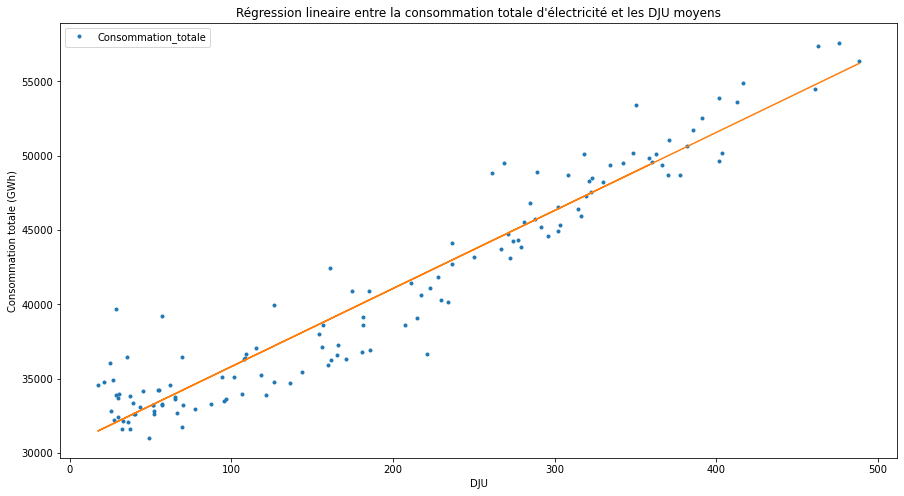

In [15]:
data_p9.plot(x='DJU', y='Consommation_totale', style='.',figsize=(15,8))
plt.plot(data_p9['DJU'], Regression_lineaire_P9.predict(sm.add_constant(data_p9['DJU'])))
plt.xlabel('DJU')
plt.ylabel('Consommation totale (GWh)')
plt.title('Régression lineaire entre la consommation totale d\'électricité et les DJU moyens')
plt.show()

In [16]:
#Coefficient de régression linéaire
Regression_lineaire_P9.params['DJU']

52.48063561029335

In [17]:
#Calcul de la correction : l'effet DJU est retranché à la consommation totale
data_p9['Conso_corr'] = data_p9['Consommation_totale'] - data_p9['DJU']*Regression_lineaire_P9.params['DJU']

# Je défini la premiere colonne comme index
data_p9.set_index("Date", inplace = True)
data_p9 = data_p9.reset_index(drop=False)

data_p9.head()

,Date,Consommation_totale,DJU,Conso_corr
0,2010-01-01,56342.0,488.5,30705.2095044
1,2010-02-01,48698.0,377.6,28881.3119936
2,2010-03-01,48294.0,321.4,31426.7237149
3,2010-04-01,38637.0,207.3,27757.7642380
4,2010-05-01,37284.0,165.9,28577.4625523


In [18]:
#data_p9.to_csv("C:/Users/33643/Desktop/P9/10052022/data_p9.csv", index=False)

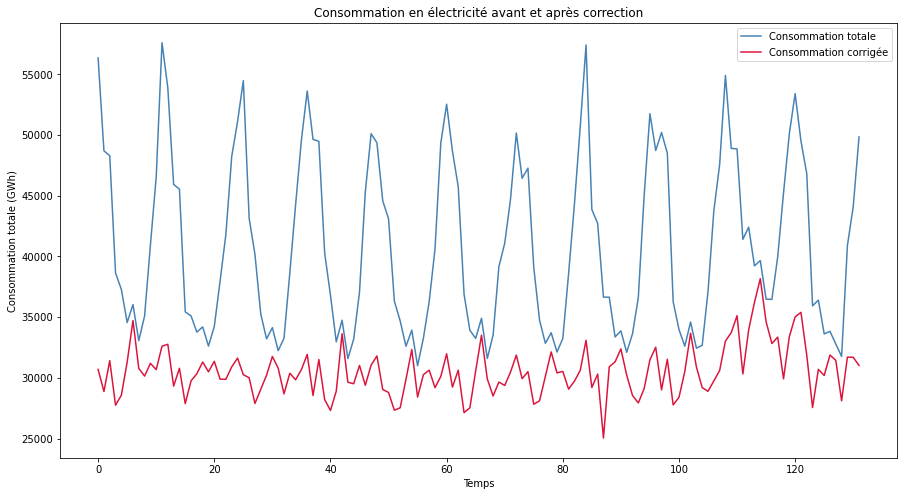

In [19]:
#Visualisation de la consommation en électricité avant et après correction
plt.figure(figsize=(15,8))
plt.plot(data_p9['Consommation_totale'], label='Consommation totale',color="steelblue")
plt.plot(data_p9['Conso_corr'], label='Consommation corrigée',color="crimson")
plt.title('Consommation en électricité avant et après correction')
plt.xlabel('Temps')
plt.ylabel('Consommation totale (GWh)')
plt.legend()
plt.show()

### En ayant corrigé la série temporelle sur la consommation d'électricité, on s'assure que les prédictions faites dans la suite de notre étude ne prenne en compte que les variations de consommation électrique sans être influencés par les variations de température extérieures.

In [20]:
data_p9_corr = data_p9.drop(columns=['Consommation_totale'],inplace=True)
data_p9_corr = data_p9.drop(columns=['DJU'])
data_p9_corr.head()

,Date,Conso_corr
0,2010-01-01,30705.2095044
1,2010-02-01,28881.3119936
2,2010-03-01,31426.7237149
3,2010-04-01,27757.7642380
4,2010-05-01,28577.4625523


In [21]:
#data_p9_corr.to_csv("D:/DA_P9/NEW/data_p9_corr.csv", index=False)

## 5.Test de normalité des résidus <a class="anchor" id="5"></a>

In [22]:
shapiro(Regression_lineaire_P9.resid)

ShapiroResult(statistic=0.9700998067855835, pvalue=0.005207356531172991)

### <font color='steelblue'> H0: Les données suivent une loi normale H1: Les données ne suivent pas une loi normale </font>

### Ici, l'hypothèse de normalité H0 n'est pas remise en cause (p-value > 0.05).

### Même si le résidu n'est pas considéré comme étant parfaitement gaussien par le test de Shapiro Wilk, l'observation des résidus ci-dessous permet de conclure que les résidus suivent la loi normale.

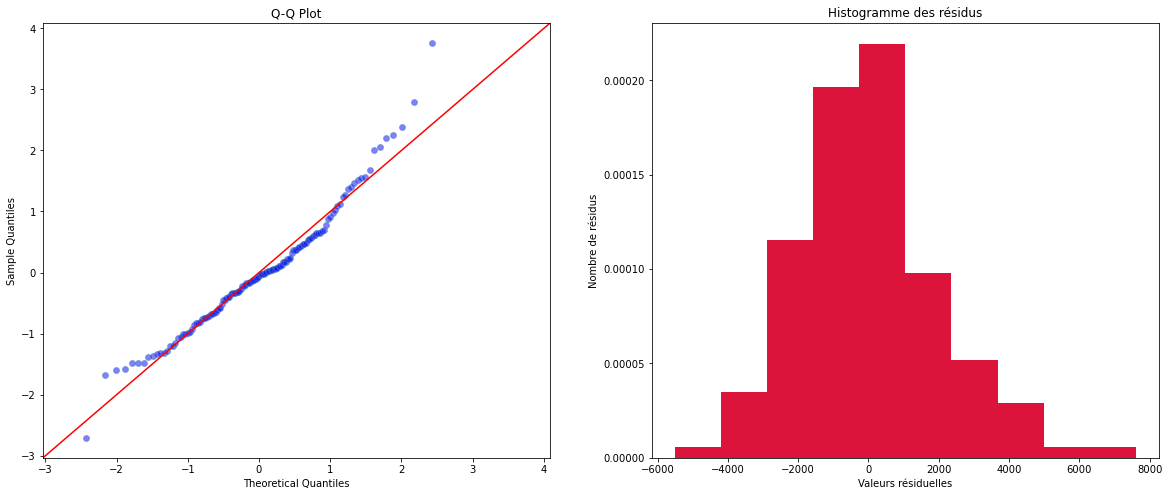

In [23]:
#Distribution des résidus
fig, ax = plt.subplots(1, 2, figsize=(20,8))

plt.hist(Regression_lineaire_P9.resid, density=True, color='crimson')

model_norm_residuals = Regression_lineaire_P9.get_influence().resid_studentized_internal
QQ = ProbPlot(model_norm_residuals)
QQ.qqplot(line='45', alpha=0.5, color='steelblue', ax=ax[0])

ax[0].set_title('Q-Q Plot')
ax[1].set_title('Histogramme des résidus')
ax[1].set_xlabel('Valeurs résiduelles')
ax[1].set_ylabel('Nombre de résidus')
                
plt.show()